# Performance of octave UNet on various retinal vessel segmentation datasets

---

This notbook layout the performance of octave UNet on various retinal vessel segmentation datasets.

In [1]:
# setup path environment
import os
import sys

project_dir, _ = os.path.split(os.getcwd())
if project_dir not in sys.path:
    sys.path.append(project_dir)

# import packages for data manipulation and drawing
import pandas as pd
import numpy as np
import scipy as sp

# for ploting inline on the notebook
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper', font_scale=1.5)

from PIL import Image
import torch
from torch.nn import functional as F
from torchvision.transforms import functional as TF


In [2]:
# read the last output result after completing training
monitor_dir = 'last'

# metrics for performance evaluation
perf_metrics = ['acc', 'se', 'sp', 'f1', 'auroc', 'ap']


## DRIVE

In [3]:
def get_data_frame(exp_dir, exp_name, perf_metrics,
                   monitor_dir='last', outputs_dir='outs',
                   perf_csv_file='performances.csv',
                   summ_csv_file='model_summary.csv'):
    """Get data frame of an experiment."""
    perf_csv_path = os.path.join(exp_dir, outputs_dir, monitor_dir, perf_csv_file)
    summ_csv_path = os.path.join(exp_dir, summ_csv_file)
    perf_df = pd.read_csv(perf_csv_path, index_col=0)
    summ_df = pd.read_csv(summ_csv_path, index_col=0)
    data_frame = perf_df
    data_frame['params (M)'] = round(int(summ_df['params']['total']) / (1000 ** 2), 2)
    data_frame['FLOPs (G)'] = round(int(summ_df['FLOPs']['total'].replace(',', '')) / (1000 ** 3), 2)
    data_frame['exp_name'] = exp_name
    return data_frame

drive_exp_dir = '../exps/ablation-study/alpha_0.5'
drive_data_frame = get_data_frame(drive_exp_dir, 'drive', perf_metrics, monitor_dir)
drive_data_frame.describe()

sample_index  weighted_binary_cross_entropy        acc         se  \
count      20.00000                      20.000000  20.000000  20.000000   
mean        9.50000                       0.204145   0.966360   0.837456   
std         5.91608                       0.005824   0.002409   0.041055   
min         0.00000                       0.191230   0.960720   0.772923   
25%         4.75000                       0.201389   0.964863   0.803613   
50%         9.50000                       0.205504   0.966974   0.832161   
75%        14.25000                       0.207420   0.968021   0.869971   
max        19.00000                       0.214225   0.970947   0.913635   

              sp         f1        prc      auroc         ap    params (M)  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  2.000000e+01   
mean    0.979030   0.812713   0.792733   0.983496   0.902760  1.654000e+01   
std     0.004289   0.013592   0.041049   0.005468   0.013497  3.645007e-15   
min     0.969474   0.789024   0.701586   0.973354   0.888551  1.654000e+01   
25%     0.976141   0.802128   0.769551   0.980438   0.893005  1.654000e+01   
50%     0.978762   0.810619   0.786794   0.983687   0.900473  1.654000e+01   
75%     0.982736   0.819319   0.830398   0.988313   0.909188  1.654000e+01   
max     0.984953   0.840371   0.856607   0.991478   0.937147  1.654000e+01   

          FLOPs (G)  
count  2.000000e+01  
mean   5.888000e+01  
std    1.458003e-14  
min    5.888000e+01  
25%    5.888000e+01  
50%    5.888000e+01  
75%    5.888000e+01  
max    5.888000e+01

In [4]:
def get_sample_index_with_metric(data_frame, metric, mode='max'):
    """Get the index of best sample across to max of min of a criterion."""
    if mode == 'max':
        idx = data_frame[metric].idxmax()
    elif mode == 'min':
        idx = data_frame[metric].idxmin()
    else:
        raise NotImplementedError
    sample_index = data_frame.loc[idx]['sample_index']
    return sample_index

drive_best_sample_index = get_sample_index_with_metric(drive_data_frame, 'auroc', 'max')
drive_worst_sample_index = get_sample_index_with_metric(drive_data_frame, 'auroc', 'min')

print('Best and worst performance on DRIVE dataset can be found on test sample #{} and test sample #{} respectively.'.format(drive_best_sample_index, drive_worst_sample_index))


Best and worst performance on DRIVE dataset can be found on test sample #18 and test sample #2 respectively.


In [5]:
def get_pil_images(exp_dir, sample_index, image_surfix, convert_mode, 
                   monitor_dir='last', outputs_dir='outs'):
    """Get images with sample index."""
    image_file = str(sample_index) + image_surfix
    image_path = os.path.join(exp_dir, outputs_dir, monitor_dir, image_file)
    pil_image = Image.open(image_path, mode='r').convert(convert_mode)
    return pil_image

from functools import partial
get_image = partial(get_pil_images, image_surfix='-images.png', convert_mode='RGB')
get_target = partial(get_pil_images, image_surfix='-targets.png', convert_mode='1')
get_probability_map = partial(get_pil_images, image_surfix='-probability_maps.png', convert_mode='L')
get_analytic = partial(get_pil_images, image_surfix='-analytic_maps.png', convert_mode='RGB')
get_binary_map = partial(get_pil_images, image_surfix='-binary_maps.png', convert_mode='1')
get_mask = partial(get_pil_images, image_surfix='-masks.png', convert_mode='1')

drive_best_image = get_image(drive_exp_dir, drive_best_sample_index)
drive_best_analytic = get_analytic(drive_exp_dir, drive_best_sample_index)

drive_worst_image = get_image(drive_exp_dir, drive_worst_sample_index)
drive_worst_analytic = get_analytic(drive_exp_dir, drive_worst_sample_index)

def plot_image_grides(images):
    rows = int(len(images) ** 0.5)
    cols = int(np.ceil(len(images) / int(len(images) ** 0.5)))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*10, rows*10))
    axes = axes.ravel()
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# uncomment the following code to visualise the best and worst performances
# plot_image_grides([drive_best_image, drive_best_analytic, 
#                    drive_worst_image, drive_worst_analytic])

## STARE

In [6]:
def get_batch_data_frame(exp_root, num_samples, exp_name, perf_metrics,
                         monitor_dir='last', outputs_dir='outs',
                         perf_csv_file='performances.csv',
                         summ_csv_file='model_summary.csv'):
    """Get data frame of instance performances from a batch of leave one out experiments."""
    data_frames = []
    for i in range(num_samples):
        exp_dir = os.path.join(exp_root, 'valid_' + str(i))
        data_frame = get_data_frame(exp_dir, exp_name, perf_metrics, 
                                    monitor_dir, outputs_dir, 
                                    perf_csv_file, summ_csv_file)
        data_frames.append(data_frame)
    data_frames = pd.concat(data_frames, ignore_index=True)
    return data_frames

stare_exp_root = '../exps/datasets/stare'
stare_num_samples = 20
stare_data_frame = get_batch_data_frame(stare_exp_root, stare_num_samples, 'stare', perf_metrics, monitor_dir)
stare_data_frame.describe()


sample_index  weighted_binary_cross_entropy        acc         se  \
count      20.00000                      20.000000  20.000000  20.000000   
mean        9.50000                       0.247191   0.971268   0.866383   
std         5.91608                       0.034888   0.006565   0.066048   
min         0.00000                       0.195461   0.956444   0.712943   
25%         4.75000                       0.213323   0.969487   0.826017   
50%         9.50000                       0.254938   0.971956   0.873866   
75%        14.25000                       0.272695   0.975860   0.923803   
max        19.00000                       0.306744   0.981838   0.956321   

              sp         f1        prc      auroc         ap    params (M)  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  2.000000e+01   
mean    0.979831   0.819078   0.782142   0.987473   0.910823  1.654000e+01   
std     0.007876   0.031804   0.052678   0.006459   0.034280  3.645007e-15   
min     0.958546   0.756268   0.662650   0.972780   0.819921  1.654000e+01   
25%     0.976383   0.801697   0.752549   0.983782   0.895424  1.654000e+01   
50%     0.982860   0.822579   0.792428   0.989086   0.909927  1.654000e+01   
75%     0.984410   0.838161   0.825761   0.993210   0.942137  1.654000e+01   
max     0.989109   0.873808   0.859067   0.995179   0.953717  1.654000e+01   

          FLOPs (G)  
count  2.000000e+01  
mean   5.888000e+01  
std    1.458003e-14  
min    5.888000e+01  
25%    5.888000e+01  
50%    5.888000e+01  
75%    5.888000e+01  
max    5.888000e+01

In [7]:
stare_best_sample_index = get_sample_index_with_metric(stare_data_frame, 'auroc', 'max')
stare_worst_sample_index = get_sample_index_with_metric(stare_data_frame, 'auroc', 'min')
stare_best_exp_dir = os.path.join(stare_exp_root, 'valid_' + str(stare_best_sample_index))
stare_worst_exp_dir = os.path.join(stare_exp_root, 'valid_' + str(stare_worst_sample_index))

stare_best_image = get_image(stare_best_exp_dir, stare_best_sample_index)
stare_best_analytic = get_analytic(stare_best_exp_dir, stare_best_sample_index)

stare_worst_image = get_image(stare_worst_exp_dir, stare_worst_sample_index)
stare_worst_analytic = get_analytic(stare_worst_exp_dir, stare_worst_sample_index)

# plot_image_grides([stare_best_image, stare_best_analytic, 
#                    stare_worst_image, stare_worst_analytic])

## CHASE_DB1

In [8]:
chase_exp_root = '../exps/datasets/chase'
chase_num_samples = 28
chase_data_frame = get_batch_data_frame(chase_exp_root, chase_num_samples, 'chase', perf_metrics, monitor_dir)
chase_data_frame.describe()


sample_index  weighted_binary_cross_entropy        acc         se  \
count     28.000000                      28.000000  28.000000  28.000000   
mean      13.500000                       0.139353   0.975886   0.866971   
std        8.225975                       0.026854   0.003789   0.033295   
min        0.000000                       0.099430   0.965748   0.794103   
25%        6.750000                       0.119331   0.973717   0.847585   
50%       13.500000                       0.141013   0.976530   0.873334   
75%       20.250000                       0.154411   0.977863   0.891312   
max       27.000000                       0.212329   0.982700   0.916254   

              sp         f1        prc      auroc         ap    params (M)  \
count  28.000000  28.000000  28.000000  28.000000  28.000000  2.800000e+01   
mean    0.984023   0.831258   0.801679   0.990516   0.918766  1.654000e+01   
std     0.005125   0.027585   0.055977   0.002860   0.021024  3.617907e-15   
min     0.970807   0.779863   0.700510   0.983253   0.878481  1.654000e+01   
25%     0.981564   0.811101   0.749260   0.989188   0.903758  1.654000e+01   
50%     0.985390   0.837728   0.822070   0.991331   0.921128  1.654000e+01   
75%     0.986830   0.852104   0.837380   0.992345   0.934802  1.654000e+01   
max     0.992177   0.878934   0.896831   0.995780   0.956773  1.654000e+01   

          FLOPs (G)  
count  2.800000e+01  
mean   5.888000e+01  
std    1.447163e-14  
min    5.888000e+01  
25%    5.888000e+01  
50%    5.888000e+01  
75%    5.888000e+01  
max    5.888000e+01

In [9]:
chase_best_sample_index = get_sample_index_with_metric(chase_data_frame, 'auroc', 'max')
chase_worst_sample_index = get_sample_index_with_metric(chase_data_frame, 'auroc', 'min')
chase_best_exp_dir = os.path.join(chase_exp_root, 'valid_' + str(chase_best_sample_index))
chase_worst_exp_dir = os.path.join(chase_exp_root, 'valid_' + str(chase_worst_sample_index))

chase_best_image = get_image(chase_best_exp_dir, chase_best_sample_index)
chase_best_analytic = get_analytic(chase_best_exp_dir, chase_best_sample_index)

chase_worst_image = get_image(chase_worst_exp_dir, chase_worst_sample_index)
chase_worst_analytic = get_analytic(chase_worst_exp_dir, chase_worst_sample_index)

# plot_image_grides([chase_best_image, chase_best_analytic, 
#                    chase_worst_image, chase_worst_analytic])

## HRF

In [10]:
hrf_exp_root = '../exps/datasets/hrf'
hrf_num_samples = 45
hrf_data_frame = get_batch_data_frame(hrf_exp_root, hrf_num_samples, 'hrf', perf_metrics)
hrf_data_frame.describe()


sample_index  weighted_binary_cross_entropy        acc         se  \
count     45.000000                      45.000000  45.000000  45.000000   
mean      21.488889                       0.117304   0.969807   0.807598   
std       13.824587                       0.026930   0.004962   0.039693   
min        0.000000                       0.085189   0.954849   0.711199   
25%       11.000000                       0.092986   0.965374   0.786844   
50%       22.000000                       0.120035   0.970844   0.807373   
75%       33.000000                       0.132634   0.974125   0.830526   
max       44.000000                       0.199772   0.978111   0.908917   

              sp         f1        prc      auroc         ap    params (M)  \
count  45.000000  45.000000  45.000000  45.000000  45.000000  4.500000e+01   
mean    0.983126   0.796275   0.792737   0.984496   0.886223  1.654000e+01   
std     0.007536   0.048873   0.095374   0.007009   0.050097  3.592859e-15   
min     0.966482   0.693338   0.606438   0.956813   0.779254  1.654000e+01   
25%     0.977417   0.767731   0.744281   0.981151   0.857099  1.654000e+01   
50%     0.983215   0.797534   0.783830   0.985085   0.887929  1.654000e+01   
75%     0.989275   0.837070   0.887864   0.988710   0.927764  1.654000e+01   
max     0.995955   0.874845   0.954240   0.993838   0.955862  1.654000e+01   

          FLOPs (G)  
count  4.500000e+01  
mean   5.888000e+01  
std    1.437143e-14  
min    5.888000e+01  
25%    5.888000e+01  
50%    5.888000e+01  
75%    5.888000e+01  
max    5.888000e+01

In [11]:
hrf_best_sample_index = get_sample_index_with_metric(hrf_data_frame, 'auroc', 'max')
hrf_worst_sample_index = get_sample_index_with_metric(hrf_data_frame, 'auroc', 'min')

hrf_best_exp_dir = os.path.join(hrf_exp_root, 'valid_' + str(hrf_best_sample_index))
hrf_worst_exp_dir = os.path.join(hrf_exp_root, 'valid_' + str(hrf_worst_sample_index))

hrf_best_image = get_image(hrf_best_exp_dir, hrf_best_sample_index)
hrf_worst_image = get_image(hrf_worst_exp_dir, hrf_worst_sample_index)

hrf_best_analytic = get_analytic(hrf_best_exp_dir, hrf_best_sample_index)
hrf_worst_analytic = get_analytic(hrf_worst_exp_dir, hrf_worst_sample_index)

# plot_image_grides([hrf_best_image, hrf_best_analytic, 
#                    hrf_worst_image, hrf_worst_analytic])

## Best and worst cases on different datasets

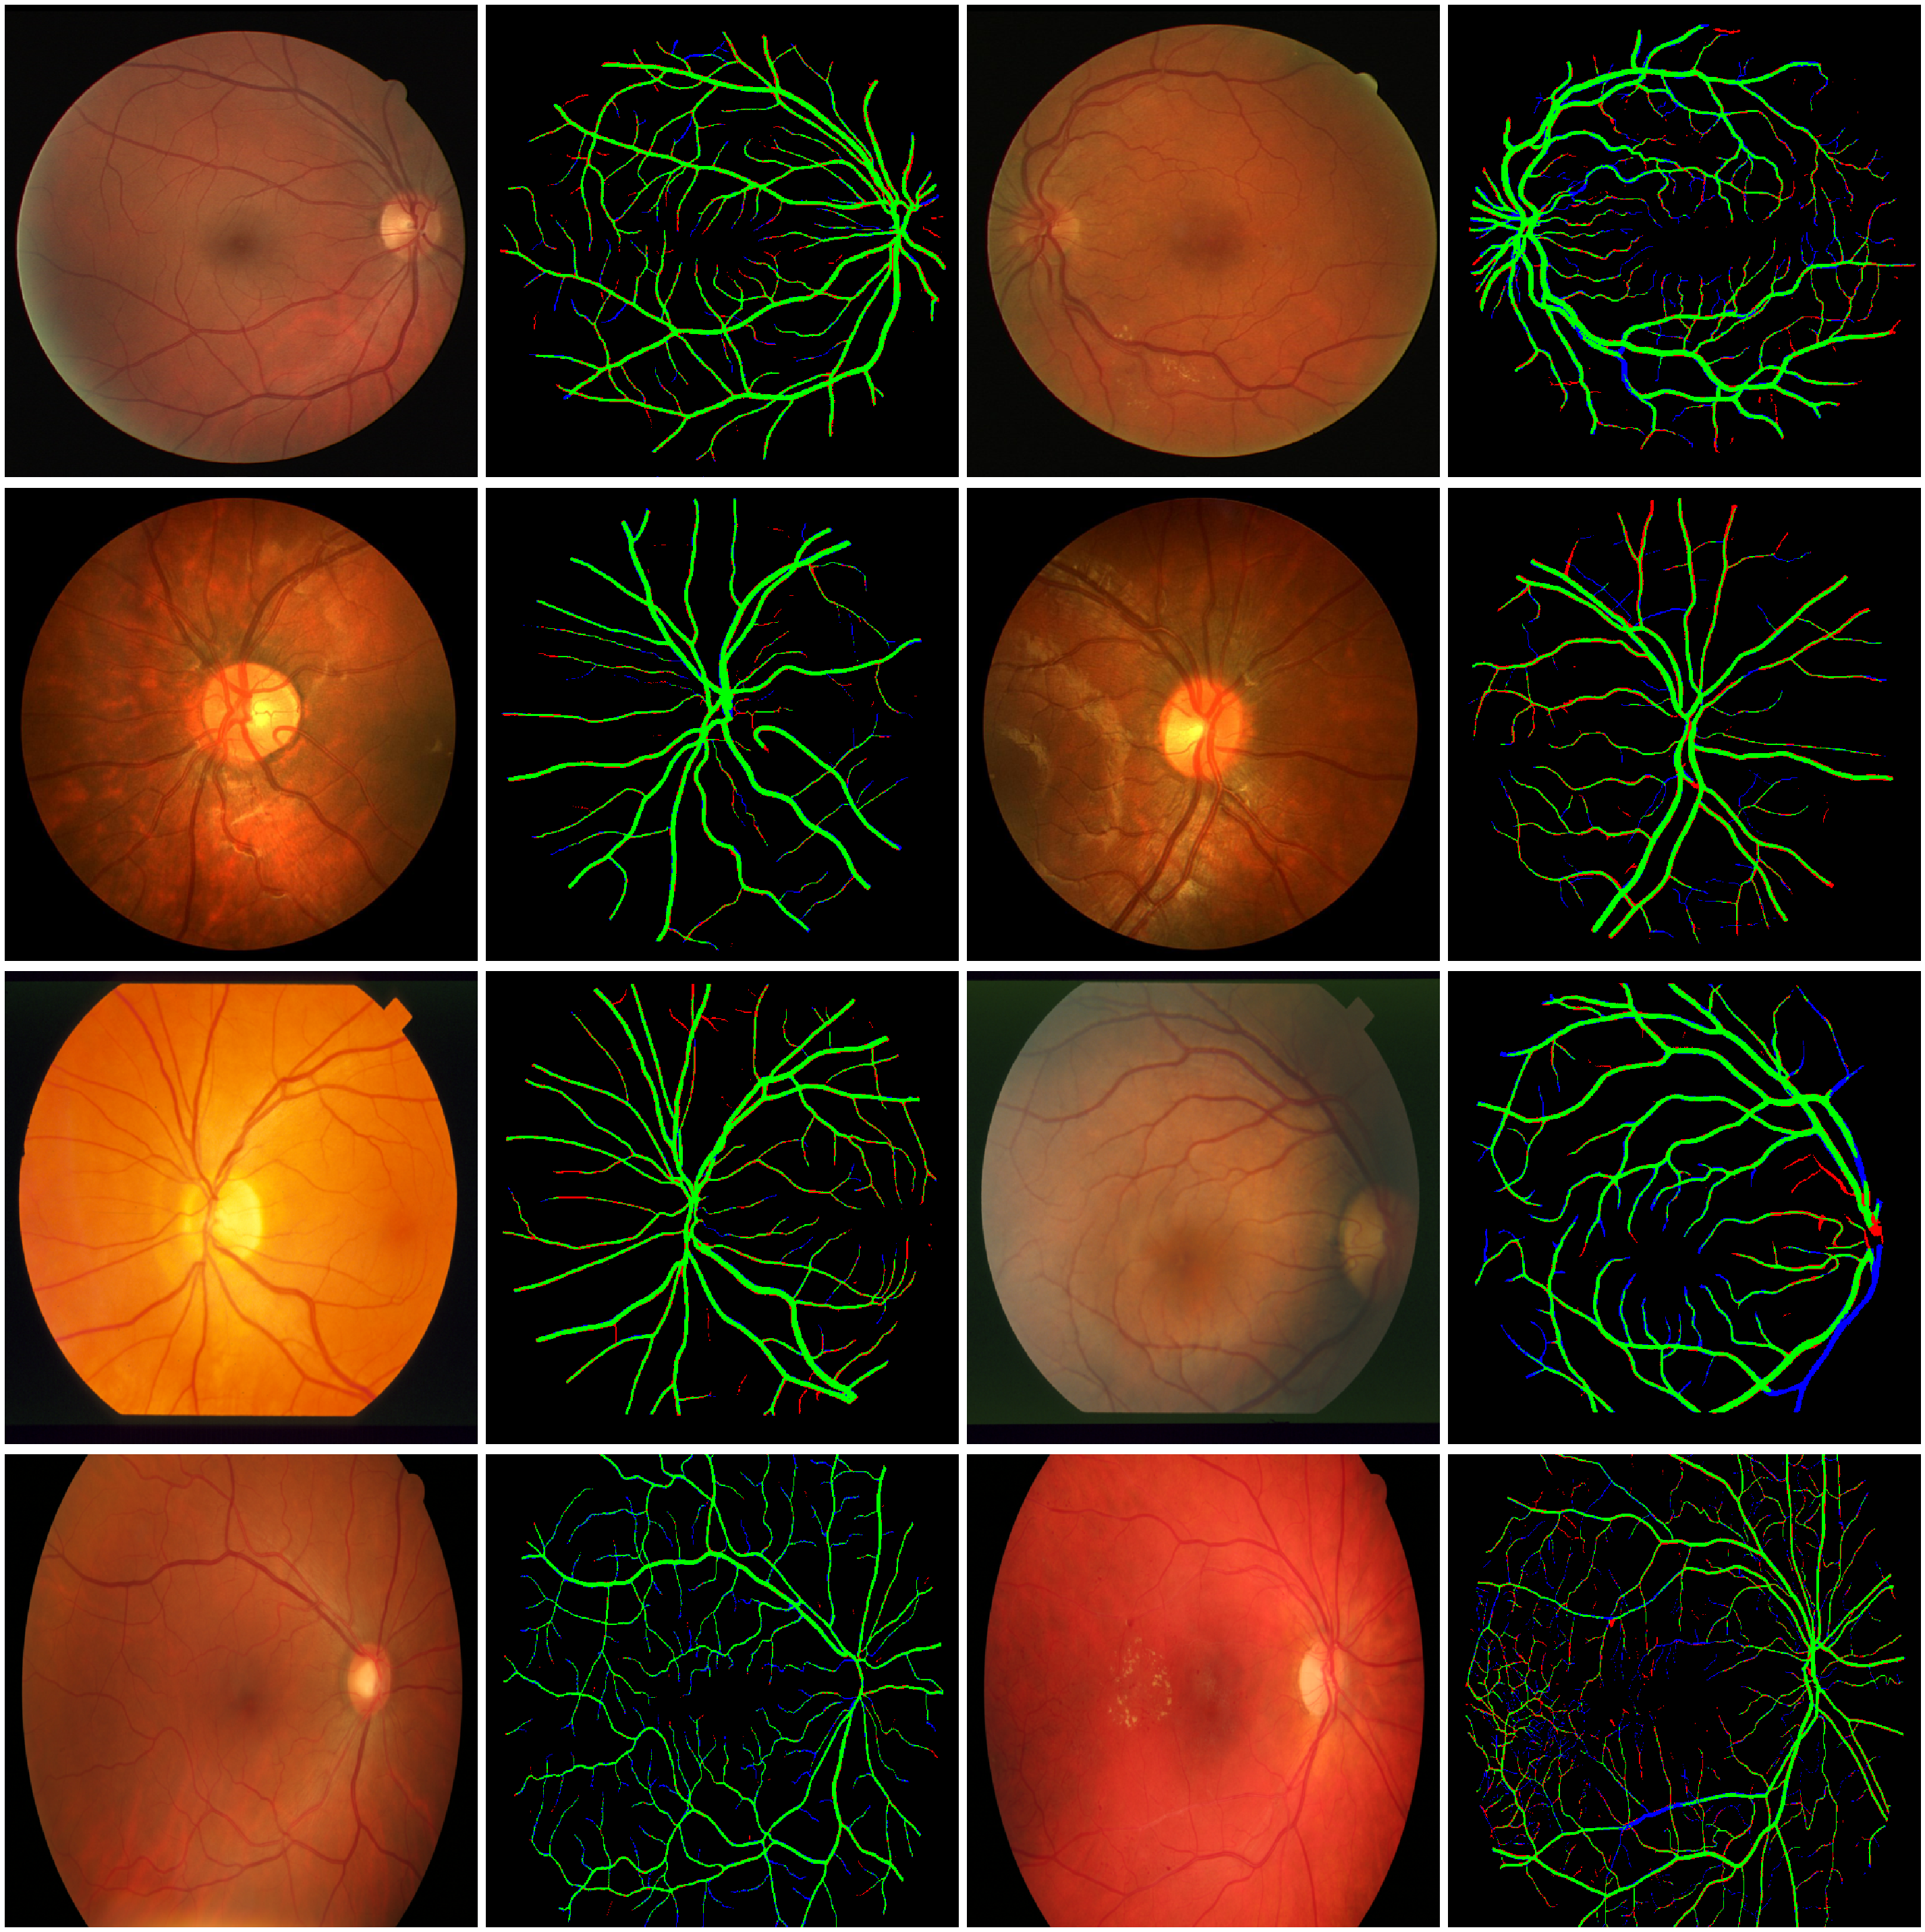

In [12]:
def plot_best_worst_cases(images, save_fig=False):
    rows = int(len(images) ** 0.5)
    cols = int(np.ceil(len(images) / int(len(images) ** 0.5)))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*10, rows*10))
    axes = axes.ravel()
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].axis('off')
    plt.tight_layout()
    if save_fig:
        try:
            os.mkdir('cases')
        except:
            pass
        plt.savefig('cases/best-and-worst-cases.pdf')
    plt.show()

plot_best_worst_cases([drive_best_image, drive_best_analytic, 
                       drive_worst_image, drive_worst_analytic,
                       chase_best_image, chase_best_analytic, 
                       chase_worst_image, chase_worst_analytic,
                       stare_best_image, stare_best_analytic, 
                       stare_worst_image, stare_worst_analytic,
                       hrf_best_image, hrf_best_analytic, 
                       hrf_worst_image, hrf_worst_analytic],
                      save_fig=True)


## Abnormal cases

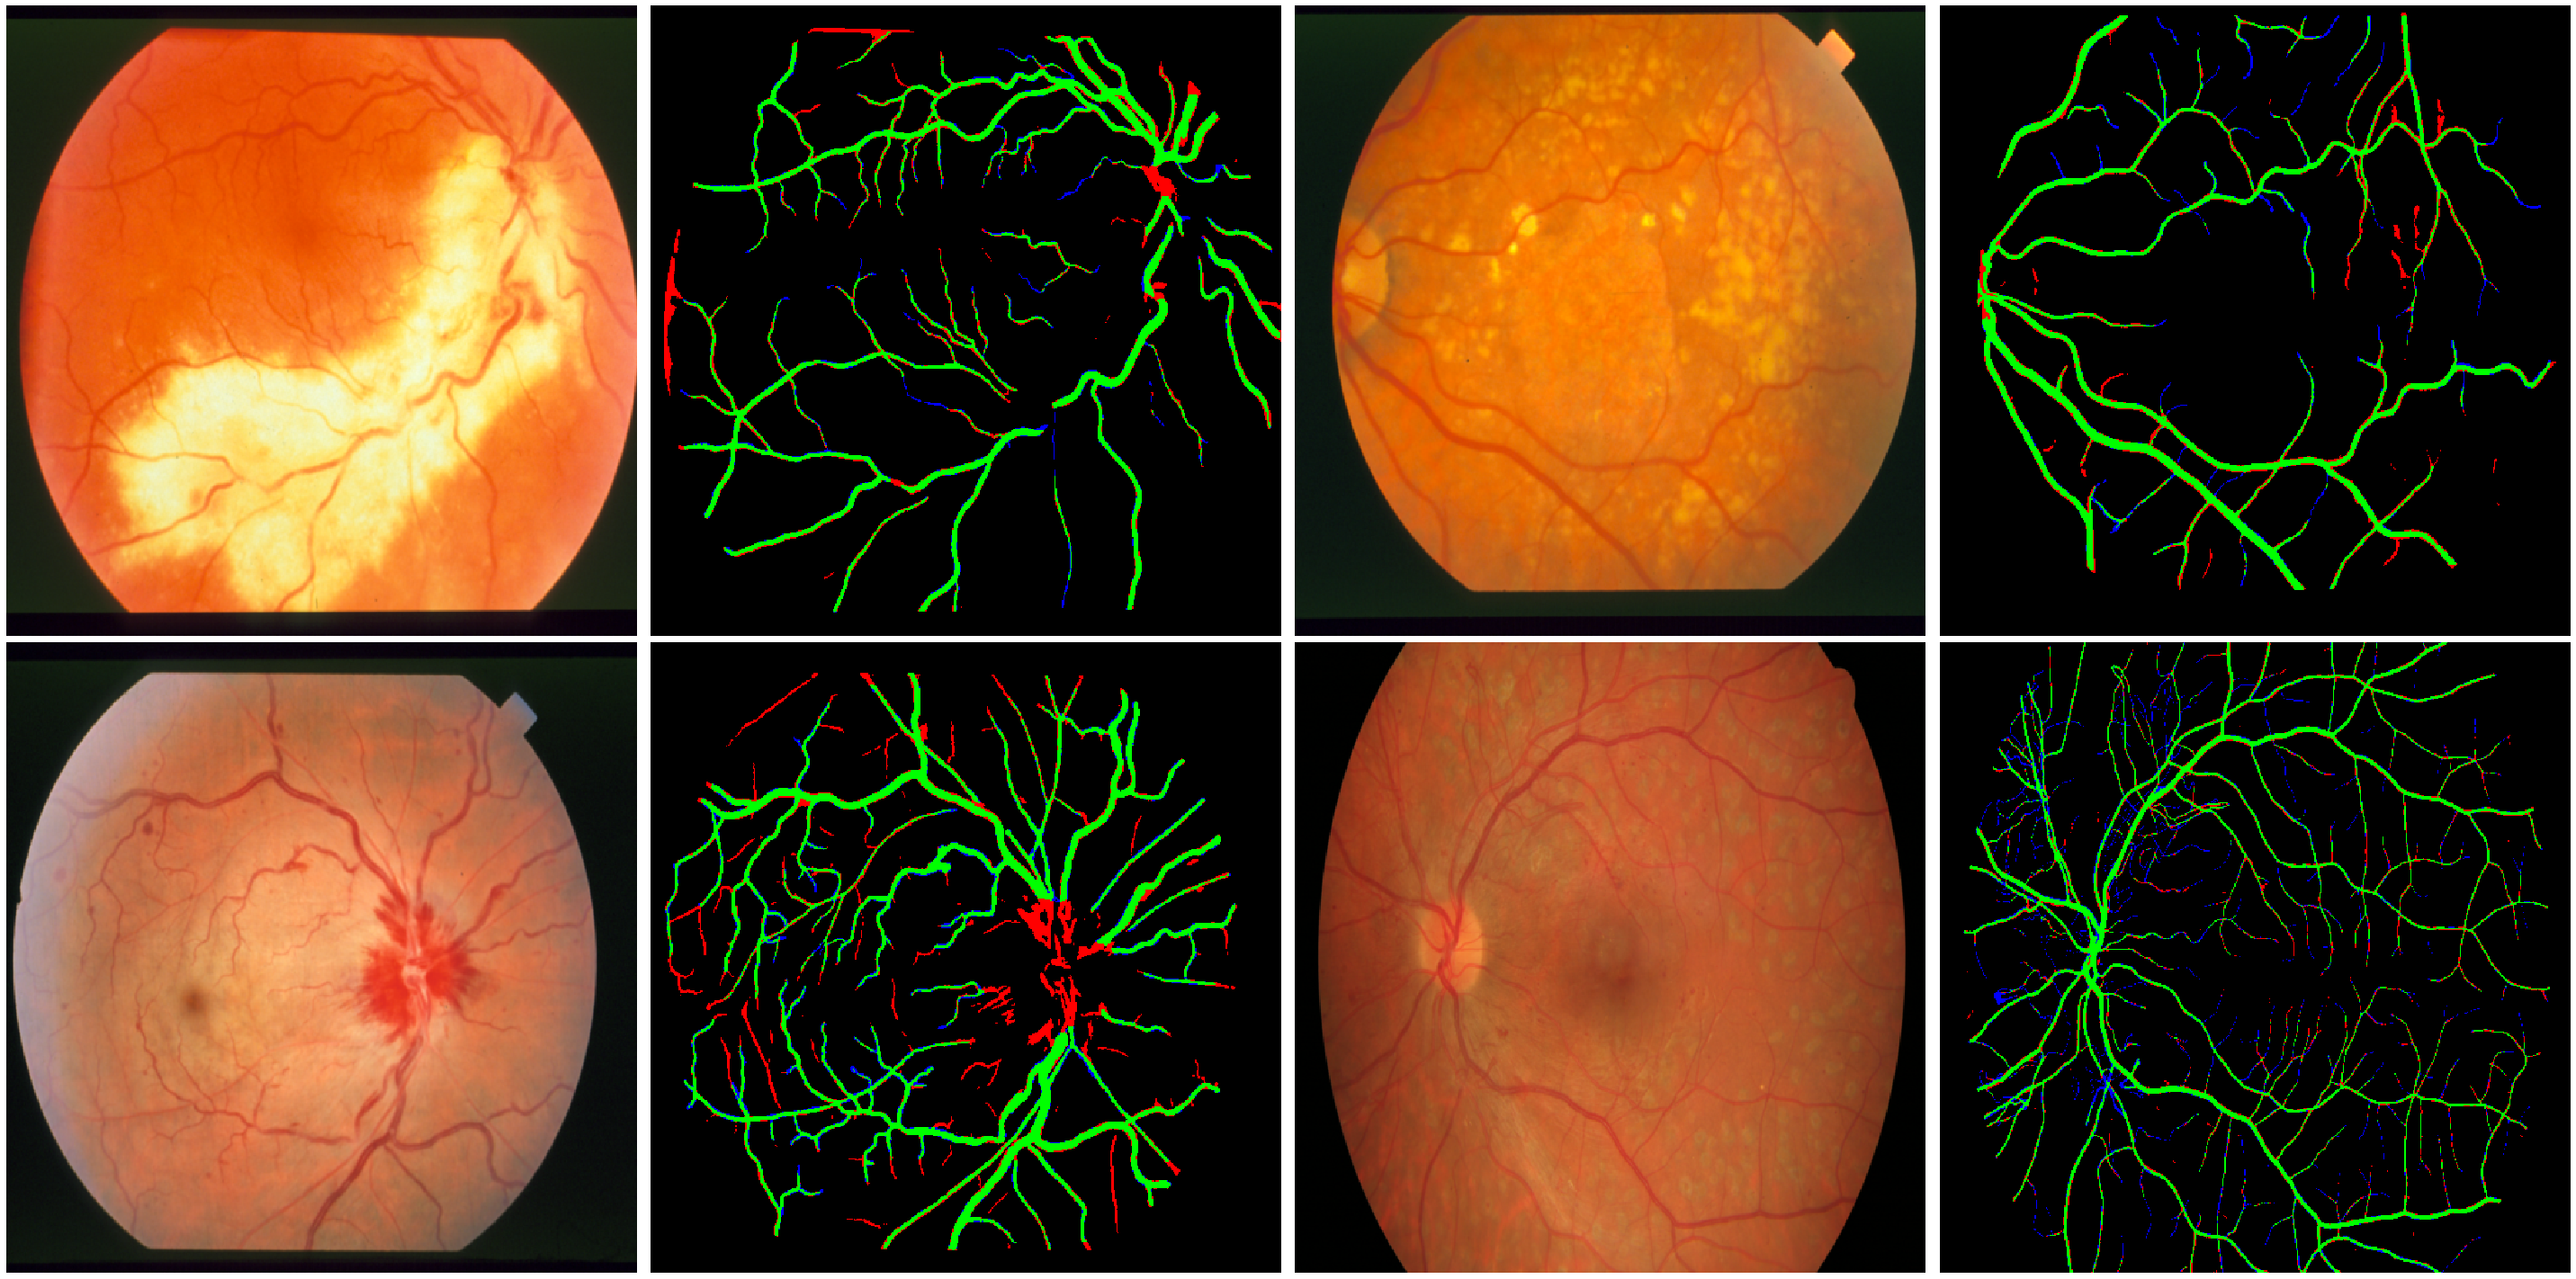

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
axes = axes.ravel()
axes[0].imshow(get_image(os.path.join(stare_exp_root, 'valid_' + str(5)), 5))
axes[0].axis('off')
axes[1].imshow(get_analytic(os.path.join(stare_exp_root, 'valid_' + str(5)), 5))
axes[1].axis('off')
axes[2].imshow(get_image(os.path.join(stare_exp_root, 'valid_' + str(2)), 2))
axes[2].axis('off')
axes[3].imshow(get_analytic(os.path.join(stare_exp_root, 'valid_' + str(2)), 2))
axes[3].axis('off')
axes[4].imshow(get_image(os.path.join(stare_exp_root, 'valid_' + str(4)), 4))
axes[4].axis('off')
axes[5].imshow(get_analytic(os.path.join(stare_exp_root, 'valid_' + str(4)), 4))
axes[5].axis('off')
axes[6].imshow(get_image(os.path.join(hrf_exp_root, 'valid_' + str(39)), 39))
axes[6].axis('off')
axes[7].imshow(get_analytic(os.path.join(hrf_exp_root, 'valid_' + str(39)), 39))
axes[7].axis('off')
plt.tight_layout()
try:
    os.mkdir('cases')
except:
    pass
plt.savefig('cases/abnormal-cases.pdf')